# Optimal Signal to Noise Ratio (SNR) generation and comparison 

This notebook is a full guide on how to use the `gwsnr` package to generate the 'optimal-SNR' ($\rho_{\rm opt}$) and 'probability of detection' (Pdet) for a given Gravitational Wave (GW) signal.

## Contents of this notebook

$\rho_{\rm opt}$ calculation with,
  - Noise-Weighted Inner Product 
  - Partial Scaling Interpolation
  - ANN-model and $P_{\rm det}$ Estimation 
  - Hybrid SNR Recalculation for $P_{\rm det}$ Estimation
  - JAX assisted Inner product with `ripplegw` as backend

Note: For more details on SNR calculation methods, please refer to the [gwsnr documentation](https://gwsnr.hemantaph.com).


## Requirements

- `gwsnr` for all SNR calculations
- `jax` and `jaxlib` for Partial Scaling Interpolation, if you want to use the jax version. `"jax[cuda12]"` for running on Nvidia GPU.
- `mlx` for Partial Scaling Interpolation, if you want to use Apple Silicon M-series GPU.
- `ripplegw` for JAX assisted Inner product method.
- `scikit-learn` and `tensorflow` for ANN model based SNR calculation. `ml-dtypes` might need to be updated to the latest version for compatibility with TensorFlow.


## Below shows GWSNR initialization with all of its (default) arguments

```python
gwsnr = gwsnr.GWSNR(
    #------------------------------
    # General settings
    npool=4,  # Number of processors for parallel processing. Run this to check the number of cores in your machine; import os; os.cpu_count()
    snr_method='interpolation_no_spins',  # SNR calculation method. Other options: 'interpolation_no_spins_jax', 'interpolation_no_spins_mlx', 'interpolation_aligned_spins', 'interpolation_aligned_spins_jax', 'interpolation_aligned_spins_mlx', 'inner_product', 'inner_product_jax', 'ann' 
    snr_type='optimal_snr', # Type of SNR to be calculated. 'matched_filter_snr' option will be available in future releases.
    gwsnr_verbose=True,  # If True, it will print all gwsnr settings
    multiprocessing_verbose=True, # If True, it will show progress bar for multiprocessing. 
    pdet_kwargs=dict(snr_th=10.0, snr_th_net=10.0, pdet_type='boolean', distribution_type='noncentral_chi2', include_optimal_snr=False, include_observed_snr=False),  # Dictionary of Pdet settings
    #------------------------------
    # Settings for interpolation grid
    mtot_min=2*4.98, # Minimum total mass (Mo) for interpolation grid. 4.98 Mo is the minimum component mass of BBH systems in GWTC-3
    mtot_max=2*112.5+10.0, # Maximum total mass (Mo) for interpolation grid. 112.5 Mo is the maximum component mass of BBH systems in GWTC-3. 10.0 Mo is added to avoid edge effects.
    ratio_min=0.1,  # Minimum mass ratio for interpolation grid
    ratio_max=1.0,  # Maximum mass ratio for interpolation grid
    spin_max=0.99,  # Maximum spin magnitude for interpolation grid. Note: spin_min= -spin_max, as in aligned spin systems.
    mtot_resolution=200,  # Number of points in total mass axis for interpolation grid
    ratio_resolution=20,  # Number of points in mass ratio axis for interpolation grid
    spin_resolution=10,  # Number of points in spin magnitude axis for interpolation grid.
    batch_size_interpolation=1000000, # Number of samples to be processed in each batch for interpolation method
    interpolator_dir='./interpolator_pickle',  # Directory to save/load the interpolator
    create_new_interpolator=False,  # If True, it will overwrite the existing interpolator
    #------------------------------
    # GW signal settings
    sampling_frequency=2048.0,  # Sampling frequency in Hz
    waveform_approximant='IMRPhenomD',  # Frequency domain waveform approximant of the GW signal
    frequency_domain_source_model='lal_binary_black_hole', # Source model for frequency domain waveform generation. 
    minimum_frequency=20.0, # Minimum frequency of the waveform in Hz
    reference_frequency=20.0, # Reference frequency for spin
    duration_max=None,  # Maximum duration of the waveform in seconds. Bilby default for IMRPhenomXPHM is 64 seconds.
    duration_min=None,  # Minimum duration of the waveform in seconds. Bilby default is 4 seconds.
    fixed_duration=None, # If a float value is provided, all waveforms will be generated with this fixed duration (in seconds).
    mtot_cut=False,  # If True, SNR=0 for total mass associated with signal duration < 1.1*chirp_duration
    #------------------------------
    # Detector settings
    psds= {'L1':'aLIGO_O4_high_asd.txt','H1':'aLIGO_O4_high_asd.txt', 'V1':'AdV_asd.txt', 'K1':'KAGRA_design_asd.txt'}, # Power spectral density of the detectors. Other options: psd names from pycbc (e.g. 'aLIGODesign'), psd via gps time (e.eg. 1234567890), or custom PSD as txt file.
    ifos=['L1', 'H1', 'V1'],  # List of detectors. You can also provide bilby interferometer objects.
    #------------------------------
    # ANN settings
    ann_path_dict=None,  # Path to the ANN model for SNR and Pdet calculation
    #------------------------------
    # Hybrid SNR recalculation settings
    snr_recalculation=False, # If True, enables hybrid SNR recalculation for systems near detection threshold. Default is False.
    snr_recalculation_range=[6,14], # SNR range [min, max] for triggering recalculation with inner product method.
    snr_recalculation_waveform_approximant='IMRPhenomXPHM', # Waveform approximant to use for SNR recalculation. Default is 'IMRPhenomXPHM'.
)
```

## Noise-Weighted Inner Product 

In [1]:
# loading GWSNR class from the gwsnr package
import gwsnr
import numpy as np

# initializing the GWSNR class with inner product as the signal-to-noise ratio type
gwsnr = gwsnr.GWSNR(
    snr_method='inner_product', 
    waveform_approximant='IMRPhenomXPHM')

# signal-to-noise ratio for a BBH with GW150914 like parameters with detectors LIGO-Hanford, LIGO-Livingston, and Virgo with O4 observing run sensitivity
snrs = gwsnr.optimal_snr(
    mass_1=np.array([36.0]), # mass of the primary black hole in solar masses
    mass_2=np.array([29.0]), # mass of the secondary black hole in solar masses
    luminosity_distance=np.array([440.0]), # luminosity distance in Mpc
    theta_jn=np.array([1.0]), # inclination angle in radians
    ra=np.array([3.435]), # right ascension in radians
    dec=np.array([-0.408]), # declination in radians
    psi=np.array([0.0]),  # polarization angle in radians
    geocent_time=np.array([1126259462.4]), # geocentric time in GPS seconds
    a_1=np.array([0.3]), # dimensionless spin of the primary black hole
    a_2=np.array([0.2]), # dimensionless spin of the secondary black hole
    tilt_1=np.array([0.5]), # tilt angle of the primary black hole in radians
    tilt_2=np.array([0.8]), # tilt angle of the secondary black hole in radians
    phi_12=np.array([0.0]), # Relative angle between the primary and secondary spin of the binary in radians
    phi_jl=np.array([0.0]), # Angle between the total angular momentum and the orbital angular momentum in radians
)

print('\nComputed SNRs with inner product:\n', snrs)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)

Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
reference frequency (f_ref):  20.0
mtot=mass1+mass2
min(mtot):  9.96
max(mtot) (with the given fmin=20.0): 235.0
detectors:  ['L1', 'H1', 'V1']
psds:  [[array([  10.21659,   10.23975,   10.26296, ..., 4972.81   ,
       4984.081  , 4995.378  ]), array([4.43925574e-41, 4.22777986e-41, 4.02102594e-41, ...,
       6.51153524e-46, 6.43165104e-46, 6.55252996e-46]), <scipy.interpolate._interpolate.interp1d object at 0x176c8efc0>], [array([  10.21659,   10.23975,   10.26296, ..., 4972.81   ,
       4984.081  , 4995.378  ]), array([4.43925574e-41, 4.22777986e

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Computed SNRs with inner product:
 {'optimal_snr_L1': array([46.53022776]), 'optimal_snr_H1': array([48.20334347]), 'optimal_snr_V1': array([13.20663045]), 'optimal_snr_net': array([68.28645184])}


## Partial Scaling Interpolation

In [2]:
import numpy as np
import gwsnr

# initializing the GWSNR class with default configuration and interpolation method
# for non-spinning IMRPhenomD waveform 
gwsnr_no_spins = gwsnr.GWSNR(
    npool=4,
    snr_method='interpolation_no_spins', # Other options: 'interpolation_no_spins_jax', 'interpolation_no_spins_mlx', 'interpolation_aligned_spins', 'interpolation_aligned_spins_jax', 'interpolation_aligned_spins_mlx'
    gwsnr_verbose=False,
    waveform_approximant='IMRPhenomD',
)

# Quick test and comparison between interpolation and inner product methods
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
dl = 1000
print('Interpolation results: ')
print(gwsnr_no_spins.optimal_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))
print('\n Inner product results: ')
print(gwsnr_no_spins.optimal_snr_with_inner_product(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_json/L1/partialSNR_dict_1.json
Interpolator will be loaded for H1 detector from ./interpolator_json/H1/partialSNR_dict_1.json
Interpolator will be loaded for V1 detector from ./interpolator_json/V1/partialSNR_dict_1.json


Interpolation results: 
{'optimal_snr_L1': array([ 7.40707612, 11.5964448 , 31.03520024, 26.59768336]), 'optimal_snr_H1': array([ 4.7108495 ,  7.37525919, 19.73817404, 16.91594381]), 'optimal_snr_V1': array([2.22222811, 3.44022184, 9.33438517, 7.86082025]), 'optimal_snr_net': array([ 9.05511885, 14.16711355, 37.94614493, 32.48658816])}

 Inner product results: 


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]

{'optimal_snr_L1': array([ 7.40686229, 11.5956576 , 31.03469553, 26.59785488]), 'optimal_snr_H1': array([ 4.71071351,  7.37475854, 19.73785306, 16.91605289]), 'optimal_snr_V1': array([2.22218338, 3.44021659, 9.33421055, 7.8608819 ]), 'optimal_snr_net': array([ 9.05486221, 14.16620729, 37.94552222, 32.4868003 ])}


## Testing speed and accuracy between the interpolation method and inner product method.

* set up the BBH Binary-Black-Holes parameters
* simulate 50000 events
* Consider IMRPhenomD waveform with aligned-spins

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gwsnr

gwsnr_aligned_spins = gwsnr.GWSNR(
    npool=4,
    snr_method='interpolation_aligned_spins', 
    gwsnr_verbose=True,
    # waveform_approximant='IMRPhenomD', # default waveform
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_json/L1/partialSNR_dict_0.json
Interpolator will be loaded for H1 detector from ./interpolator_json/H1/partialSNR_dict_0.json
Interpolator will be loaded for V1 detector from ./interpolator_json/V1/partialSNR_dict_0.json

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_aligned_spins
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
reference frequency (f_ref):  20.0
mtot=mass1+mass2
min(mtot):  9.96
max(mtot) (with the given fmin=20.0): 235.0
detectors:  ['L1', 'H1', 'V1']
psds:  [[array([  10.21659,   10.23975,   10.26296, ..., 4972.81   ,
       4984.081  , 4995.378  ]), array([4.43925574e-41, 4.22777986e-41, 4.02102594e-41, ...,
       6.51153524e-46, 6.43165104e-46, 6.55252996e-46]), <scipy.interpolate._interpolate.interp1d object at 0x14d996430>], [array([  10.21659,   10.

In [4]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(42)
nsamples = 10000
mtot = np.random.uniform(2*4.98, 2*112.5,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    # convert to component masses
    mass_1 = mtot / (1 + mass_ratio),
    mass_2 = mtot * mass_ratio / (1 + mass_ratio),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(-np.pi/2,np.pi/2, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
)

In [5]:
# for non-spinning IMRPhenomD waveform 
# running it for the first time will take longer, as the jit code generate the compiled code
start_time = datetime.now()
interp_snr_aligned_spins = gwsnr_aligned_spins.optimal_snr(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration interpolation: {}'.format(end_time - start_time))

Duration interpolation: 0:00:03.864761


In [6]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_snr = gwsnr_aligned_spins.optimal_snr_with_inner_product(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration inner-product: {}'.format(end_time - start_time))

100%|███████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2751.43it/s]

Duration inner-product: 0:00:03.718541


* interpolation method is much faster than inner product method (multiprocessing)

### Accuracy check plot

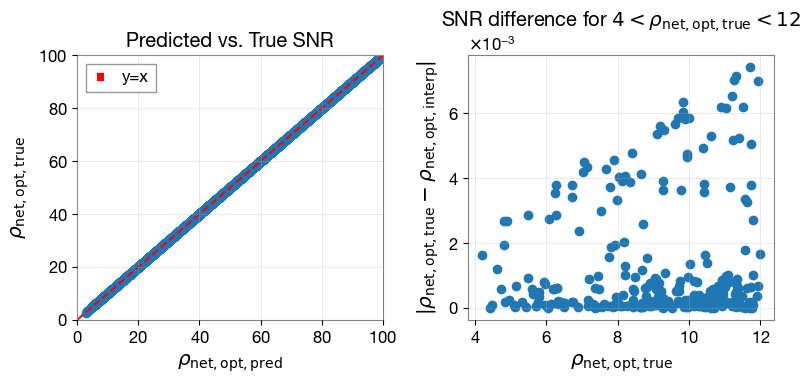

In [8]:
# compare the SNRs
plt.figure(figsize=(8,4))

# Left panel: rho_pred vs rho_true
plt.subplot(1, 2, 1)
plt.plot(bilby_snr['optimal_snr_net'], interp_snr_aligned_spins['optimal_snr_net'], 'o', color='C0')
# diagonal line
max_ = 100
min_ = 0
plt.plot([min_, max_], [min_, max_], 'r--', label='y=x')
plt.xlabel(r"$\rho_{\rm net, opt, pred}$")
plt.ylabel(r"$\rho_{\rm net, opt, true}$")
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(min_, max_)
plt.ylim(min_, max_)
plt.legend()
plt.title(r"Predicted vs. True SNR")
plt.grid(alpha=0.4)

# Right panel: SNR difference
plt.subplot(1, 2, 2)
idx = (bilby_snr['optimal_snr_net'] > 4) & (bilby_snr['optimal_snr_net'] < 12)
plt.plot(bilby_snr['optimal_snr_net'][idx], abs(interp_snr_aligned_spins['optimal_snr_net'][idx]-bilby_snr['optimal_snr_net'][idx]), 'o', color='C0')
plt.xlabel(r"$\rho_{\rm net, opt, true}$")
plt.ylabel(r"$|\rho_{\rm net, opt, true} - \rho_{\rm net, opt, interp}|$")
plt.title(r"SNR difference")
plt.grid(alpha=0.4)
plt.title(r"SNR difference for $4 < \rho_{\rm net, opt, true} < 12$")
plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

In [9]:
# percentage difference
percent_diff = 100 * abs(interp_snr_aligned_spins['optimal_snr_net'] - bilby_snr['optimal_snr_net']) / bilby_snr['optimal_snr_net']
print(f"Maximum percentage difference between interpolated and bilby SNRs: {np.max(percent_diff):.2f}%")
# absolute difference
print(f"Maximum absolute difference between interpolated and bilby SNRs: {np.max(abs(interp_snr_aligned_spins['optimal_snr_net'] - bilby_snr['optimal_snr_net'])):.4f}")

Maximum percentage difference between interpolated and bilby SNRs: 0.08%
Maximum absolute difference between interpolated and bilby SNRs: 0.1853


Note: There can be indeed some outliers with higher SNR difference, which correspond to the edge cases with high total mass and/or low mass ratio. Events that have negative chirp-times, and likely merge outside (below) the frequency band of interest, can also be found in the outliers.

## ANN-model and $P_{\rm det}$ Estimation 

* for more details on $P_{\rm det}$ calculation, please refer to the [Pdet Description](https://gwsnr.hemantaph.com/probabilityofdetection.html) page.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import gwsnr

# it will take a while to gerenerate interpolation data for precessing systems.
# interpolation is used for the partial-SNR computation.
# partial-SNR is one of the inputs to compute the full SNR using ANN models.
gwsnr_ann = gwsnr.GWSNR(
    npool=4,
    snr_method='ann', 
    waveform_approximant='IMRPhenomXPHM', 
    gwsnr_verbose=False,
    # ann_path_dict='./ann_data/ann_path_dict.json',  # ann_path_dict can be used if you generate your own ANN models
)

gwsnr_bilby = gwsnr.GWSNR(
    npool=4,
    snr_method='inner_product', 
    waveform_approximant='IMRPhenomXPHM', 
    gwsnr_verbose=False,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
Copying ANN data from the library resource /Users/phurailatpamhemantakumar/phd/mypackages/gwsnr/gwsnr/ann/ann_data to the current working directory.
ANN model and scaler path is not given. Using the default path.
ANN model for L1 is loaded from ./ann_data/ann_model_L1.h5.
ANN scaler for L1 is loaded from ./ann_data/scaler_L1.pkl.
ANN error_adjustment for L1 is loaded from ./ann_data/error_adjustment_L1.json.
ANN model for H1 is loaded from ./ann_data/ann_model_H1.h5.
ANN scaler for H1 is loaded from ./ann_data/scaler_H1.pkl.
ANN error_adjustment for H1 is loaded from ./ann_data/error_adjustment_H1.json.
ANN model for V1 is loaded from ./ann_data/ann_model_V1.h5.
ANN scaler for V1 is loaded from ./ann_data/scaler_V1.pkl.
A

/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnr/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|█████████████████████████████████████████████████████| 400000/400000 [05:15<00:00, 1266.52it/s]



Saving Partial-SNR for L1 detector with shape (20, 200, 10, 10)

Saving Partial-SNR for H1 detector with shape (20, 200, 10, 10)

Saving Partial-SNR for V1 detector with shape (20, 200, 10, 10)



Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)




In [11]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(42)
nsamples = 10000
mtot = np.random.uniform(2*4.98, 2*112.5,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    # convert to component masses
    mass_1 = mtot / (1 + mass_ratio),
    mass_2 = mtot * mass_ratio / (1 + mass_ratio),
    # Fix luminosity distance
    luminosity_distance = np.random.uniform(100, 10000, size=nsamples),  # Random luminosity distance between 100 and 10000 Mpc
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(-np.pi/2,np.pi/2, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    # spin zero
    a_1 = np.random.uniform(0.0,0.8, size=nsamples),
    a_2 = np.random.uniform(0.0,0.8, size=nsamples),
    tilt_1 = np.random.uniform(0, np.pi, size=nsamples),  # tilt angle of the primary black hole in radians
    tilt_2 = np.random.uniform(0, np.pi, size=nsamples),
    phi_12 = np.random.uniform(0, 2*np.pi, size=nsamples),  # Relative angle between the primary and secondary spin of the binary in radians
    phi_jl = np.random.uniform(0, 2*np.pi, size=nsamples),  # Angle between the total angular momentum and the orbital angular momentum in radians
)

# ANN model method
ann_pdet = gwsnr_ann.pdet(gw_param_dict=param_dict.copy(), pdet_type='boolean', distribution_type='fixed_snr')

# inner product method
bilby_pdet = gwsnr_bilby.pdet(gw_param_dict=param_dict.copy(), pdet_type='boolean', distribution_type='fixed_snr')

100%|████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 678.21it/s]


In [12]:
# accuracy of the probability of detection
from sklearn.metrics import confusion_matrix, accuracy_score

pdet_pred = ann_pdet['pdet_net']
pdet_true = bilby_pdet['pdet_net']

cm = confusion_matrix(pdet_true, pdet_pred)
print("Confusion Matrix:")
print(cm)

acc = accuracy_score(pdet_true, pdet_pred)
print(f"Accuracy: {acc*100:.2f} %")

Confusion Matrix:
[[6151  209]
 [ 126 3514]]
Accuracy: 96.65 %


## Hybrid SNR Recalculation for $P_{\rm det}$ Estimation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gwsnr


gwsnr_hybrid = gwsnr.GWSNR(
    npool=4,
    snr_method='ann',
    waveform_approximant='IMRPhenomXPHM',  # Use a specific waveform approximant
    gwsnr_verbose=False,
    snr_recalculation=True,  # Enable recalculation of SNRs
    snr_recalculation_range=[6,18],  # Range of optimal SNR for recalculation
    snr_recalculation_waveform_approximant='IMRPhenomXPHM',  # Waveform approximant for recalculation. This can be different from the main one
)

gwsnr_bilby = gwsnr.GWSNR(
    npool=4,
    snr_method='inner_product', 
    waveform_approximant='IMRPhenomXPHM', 
    gwsnr_verbose=False,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
ANN model and scaler path is not given. Using the default path.
ANN model for L1 is loaded from ./ann_data/ann_model_L1.h5.
ANN scaler for L1 is loaded from ./ann_data/scaler_L1.pkl.
ANN error_adjustment for L1 is loaded from ./ann_data/error_adjustment_L1.json.
ANN model for H1 is loaded from ./ann_data/ann_model_H1.h5.
ANN scaler for H1 is loaded from ./ann_data/scaler_H1.pkl.
ANN error_adjustment for H1 is loaded from ./ann_data/error_adjustment_H1.json.
ANN model for V1 is loaded from ./ann_data/ann_model_V1.h5.
ANN scaler for V1 is loaded from ./ann_data/scaler_V1.pkl.
ANN error_adjustment for V1 is loaded from ./ann_data/error_adjustment_V1.json.
Interpolator will be loaded for L1 detector from ./interpolator_json/L

/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnr/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(





Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)




In [14]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(42)
nsamples = 10000
mtot = np.random.uniform(2*4.98, 2*112.5,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    # convert to component masses
    mass_1 = mtot / (1 + mass_ratio),
    mass_2 = mtot * mass_ratio / (1 + mass_ratio),
    # Fix luminosity distance
    luminosity_distance = np.random.uniform(100, 10000, size=nsamples),  # Random luminosity distance between 100 and 10000 Mpc
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(-np.pi/2,np.pi/2, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    # spin zero
    a_1 = np.random.uniform(0.0,0.8, size=nsamples),
    a_2 = np.random.uniform(0.0,0.8, size=nsamples),
    tilt_1 = np.random.uniform(0, np.pi, size=nsamples),  # tilt angle of the primary black hole in radians
    tilt_2 = np.random.uniform(0, np.pi, size=nsamples),
    phi_12 = np.random.uniform(0, 2*np.pi, size=nsamples),  # Relative angle between the primary and secondary spin of the binary in radians
    phi_jl = np.random.uniform(0, 2*np.pi, size=nsamples),  # Angle between the total angular momentum and the orbital angular momentum in radians
)

# ANN model method, with SNR recalculation
hybrid_pdet = gwsnr_hybrid.pdet(gw_param_dict=param_dict.copy(), pdet_type='boolean', distribution_type='fixed_snr')

# inner product method
bilby_pdet = gwsnr_bilby.pdet(gw_param_dict=param_dict.copy(), pdet_type='boolean', distribution_type='fixed_snr')

Recalculating SNR for 3776 out of 10000 samples in the SNR range of 6 to 18


100%|████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 720.07it/s]


In [15]:
# accuracy of the probability of detection
from sklearn.metrics import confusion_matrix, accuracy_score

pdet_pred = hybrid_pdet['pdet_net']
pdet_true = bilby_pdet['pdet_net']

cm = confusion_matrix(pdet_true, pdet_pred)
print("Confusion Matrix:")
print(cm)

acc = accuracy_score(pdet_true, pdet_pred)
print(f"Accuracy: {acc*100:.2f} %")

Confusion Matrix:
[[6360    0]
 [   1 3639]]
Accuracy: 99.99 %


## JAX assisted Inner product with `ripplegw` as backend

In [16]:
import numpy as np
import gwsnr

# innitialize the class for pdet calculation
gwsnr = gwsnr.GWSNR(
    snr_method='inner_product_jax', 
    waveform_approximant='IMRPhenomXAS', 
    gwsnr_verbose=False,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds




In [18]:
# set the GW parameters
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
param_dict = dict(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    a_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    a_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)

# jax.jit functions are slow when run for the first time
snr_jax = gwsnr.optimal_snr(gw_param_dict=param_dict)
print("SNR (inner product JAX assisted) : ", snr_jax['optimal_snr_net'])

# snr with inner product
snr_bilby = gwsnr.optimal_snr_with_inner_product(gw_param_dict=param_dict)
print("SNR (inner product bilby) : ", snr_bilby['optimal_snr_net'])

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.82it/s]

SNR (inner product JAX assisted) :  [11.35192063  9.22035654 17.49730142 17.53788394]



100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.89it/s]

SNR (inner product bilby) :  [11.35192174  9.22036535 17.49712218 17.53863404]


* as of 27 Oct 2025, jax implementation of inner product is not fully optimized yet.

* While the waveform generation is fast via `jax.vamp` parallelization, the overall inner product calculation has extra overhead which will be optimized in the future.

## Changing the initialization arguments

To change the initialization arguments, you can modify the `GWSNR` class initialization parameters. Below is an example of how to set up the `GWSNR` class with different parameters:

What will change in this example? 

* ifos: CE, ET ; interferometers will be changed to Cosmic Explorer (CE) and Einstein Telescope (ET). 

* minimum_frequency: 10 Hz

* mtot_cut: True ; this will set SNR=0 for total mass > mtot_max, and mtot_max is set according to chirp_time and minimum frequency.

* Waveform model: TaylorF2

* multiprocessing_verbose: False ; The progress bar won't be shown but the calculation will be faster.

* mtot_min: 2*1.0 ; minimum total mass in solar masses Mo. 1.0 Mo is the minimum component mass of BNS systems in GWTC-3

* snr_method: 'interpolation_no_spins_jax' ; this will use the interpolation method with no spins and JAX acceleration.

In [19]:
# if snr_method = 'inner_product', interpolator will not be created
import gwsnr
gwsnr = gwsnr.GWSNR(
    npool = int(8), 
    minimum_frequency = 10.,
    mtot_min = 2*1,  
    mtot_cut=True,
    waveform_approximant='TaylorF2',
    snr_method = 'interpolation_no_spins_jax',
    #psds = {'CE':'CE_psd.txt', 'ET':'ET_B_psd.txt'}, # if you want to use your own psd
    ifos = ['CE', 'ET'],  # this will considet bilby's default psd of CE and ET
    multiprocessing_verbose=False,
)


Initializing GWSNR class...

Interpolator will be generated for CE detector at ./interpolator_json/CE/partialSNR_dict_0.json
Interpolator will be generated for ET1 detector at ./interpolator_json/ET1/partialSNR_dict_0.json
Interpolator will be generated for ET2 detector at ./interpolator_json/ET2/partialSNR_dict_0.json
Interpolator will be generated for ET3 detector at ./interpolator_json/ET3/partialSNR_dict_0.json
Please be patient while the interpolator is generated
Generating interpolator for ['CE', 'ET1', 'ET2', 'ET3'] detectors

Saving Partial-SNR for CE detector with shape (20, 200)

Saving Partial-SNR for ET1 detector with shape (20, 200)

Saving Partial-SNR for ET2 detector with shape (20, 200)

Saving Partial-SNR for ET3 detector with shape (20, 200)

Chosen GWSNR initialization parameters:

npool:  8
snr type:  interpolation_no_spins_jax
waveform approximant:  TaylorF2
sampling frequency:  2048.0
minimum frequency (fmin):  10.0
reference frequency (f_ref):  10.0
mtot=mass1+m

In [20]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
dl = 10000 * np.ones_like(mass_1)
gwsnr.optimal_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl)

{'optimal_snr_CE': array([ 22.20392799,  36.01436234, 112.26751709, 131.33247375]),
 'optimal_snr_ET1': array([1.57145751, 2.54927254, 7.9575057 , 9.31898499]),
 'optimal_snr_ET2': array([ 4.48666096,  7.27841663, 22.71943855, 26.60659027]),
 'optimal_snr_ET3': array([ 4.99195719,  8.09812546, 25.27814484, 29.60307503]),
 'optimal_snr_net': array([ 23.2493782 ,  37.71058273, 117.56902313, 137.54750061])}